# fNIRS signal processing basics with MNE-Python

> Written by Johann Benerradi (August 2020)

In this tutorial we will use data from Herff et al., 2014 that can be requested [here](https://www.csl.uni-bremen.de/CorpusData/download.php?crps=fNIRS). This dataset consists in fNIRS brain recordings on n-back tasks.

Each file contains multiple variables:
```
subject[id].mat
    - chars
    - events
    - data
    - label
```
- `chars` contains the displayed letter for every sample.
- `events` contains keypress events of the subject.
- `label` contains information about trials for each sample (`0`: pause, `1`: 1-back, `2`: 2-back, `3`: 3-back, `4`: relax, `5`: next task, and `-1`: long break).
- `data` contains the HbO (oxyhemoglobin) and HbR (deoxyhemoglobin) data for each channel.

For fNIRS processing, we are going to use [MNE-Python](https://mne.tools/stable/index.html) that can be installed with the following command:

In [ ]:
!pip install mne

---

In [2]:
import mne
import numpy as np
import scipy.io

## Loading raw data

**We first load the MATLAB file of `subject1`:**

In [3]:
file_path = '../../data/dataset_herff_2014/subject1.mat'
mat = scipy.io.loadmat(file_path)

**We define the sampling frequency, channel names and channel types thanks to information found in the `readme.txt` file:**

In [4]:
SFREQ = 25  # Hz
CH_NAMES = ['CH1 HbO', 'CH1 HbR', 'CH2 HbO', 'CH2 HbR',
            'CH3 HbO', 'CH3 HbR', 'CH4 HbO', 'CH4 HbR',
            'CH5 HbO', 'CH5 HbR', 'CH6 HbO', 'CH6 HbR',
            'CH7 HbO', 'CH7 HbR', 'CH8 HbO', 'CH8 HbR']
CH_TYPES = ['hbo', 'hbr', 'hbo', 'hbr',
            'hbo', 'hbr', 'hbo', 'hbr',
            'hbo', 'hbr', 'hbo', 'hbr',
            'hbo', 'hbr', 'hbo', 'hbr']

**We get channel data (HbO and HbR concentration changes):**

In [5]:
delta_hb = mat['data']  # concentrations in uM
delta_hb = delta_hb * 1e-6  # convert uM to M for MNE

**We then create an MNE-Python Raw object:**

In [6]:
# Create information required for the MNE-Python Raw object
info = mne.create_info(ch_names=CH_NAMES, sfreq=SFREQ, ch_types=CH_TYPES)

# Create MNE-Python Raw object from delta_hb
raw = mne.io.RawArray(delta_hb, info)

Creating RawArray with float64 data, n_channels=16, n_times=55454
    Range : 0 ... 55453 =      0.000 ...  2218.120 secs
Ready.


**Right away, we can already plot this data:**

Using matplotlib as 2D backend.


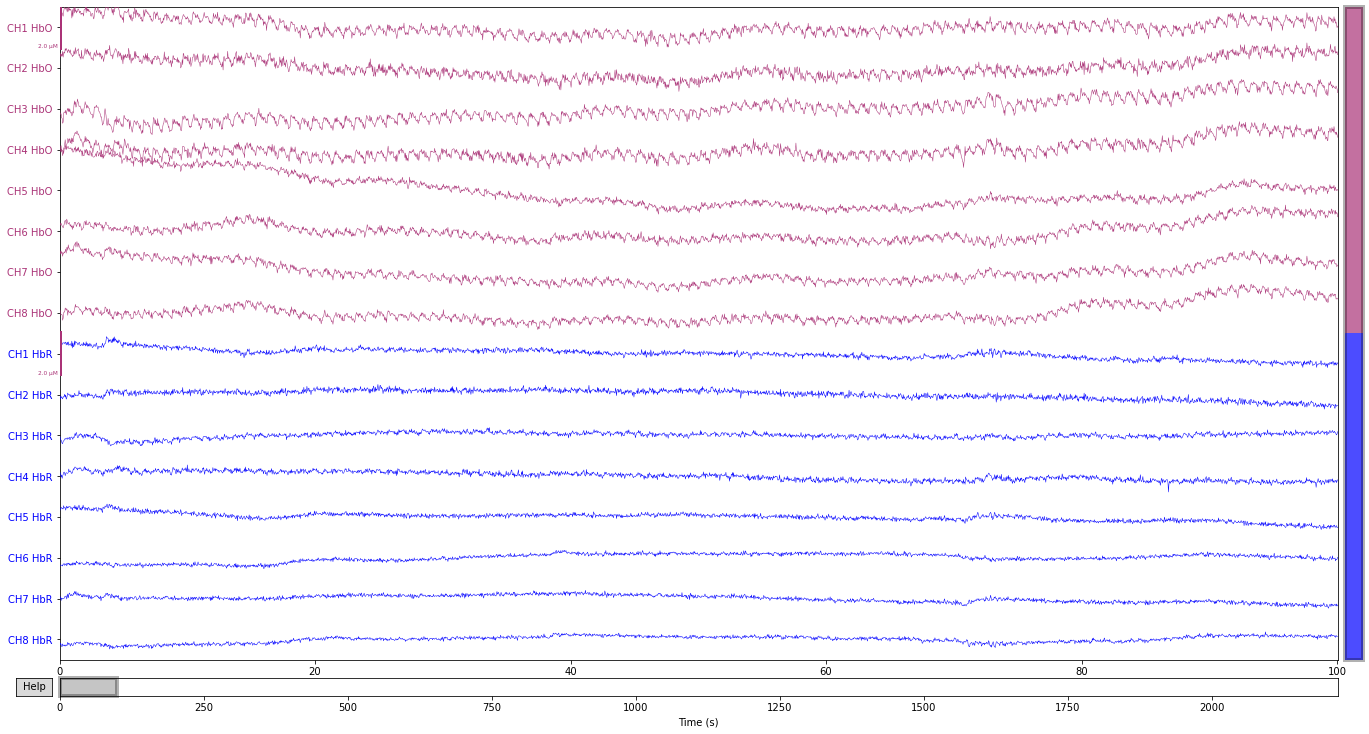

In [7]:
graph = raw.plot(scalings=1e-6, duration=100)

## Epochs

**We get stimulus data (labels corresponding to the different conditions):**

In [8]:
stim = mat['label']
stim[stim == -1] = 6  # replace -1 by 6 to avoid error

We now have the following labels: `0` for pause, `1` for 1-back, `2` for 2-back, `3` for 3-back, `4` for relax, `5` for next task, and `6` for long break.

**Now, we want to create another MNE-Python Raw object with a stimulation channel containing the different labels:**

Creating RawArray with float64 data, n_channels=1, n_times=55454
    Range : 0 ... 55453 =      0.000 ...  2218.120 secs
Ready.


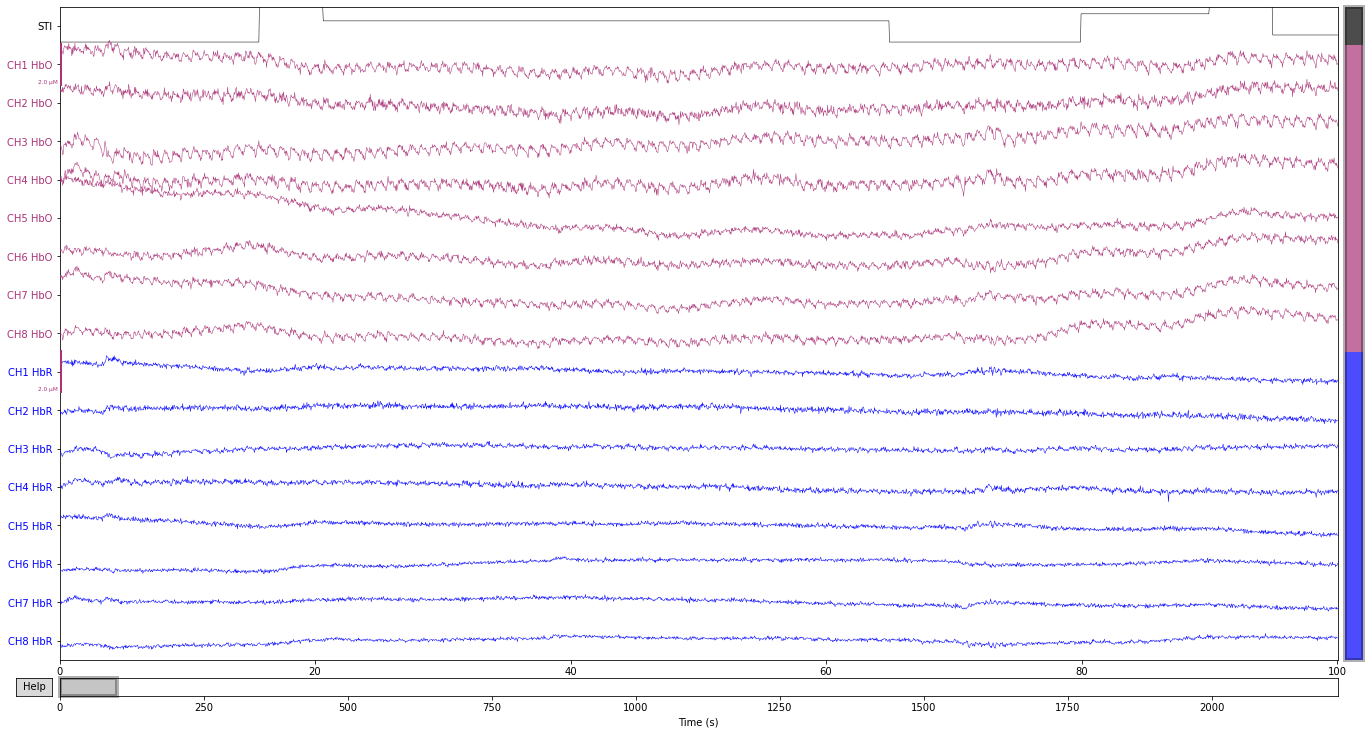

In [9]:
# Create information required for the MNE-Python Raw object
info_stim = mne.create_info(['STI'], SFREQ, ['stim'])

# Create MNE-Python Raw object from stim
raw_stim = mne.io.RawArray(stim, info_stim)

# Append raw_stim to raw
raw.add_channels([raw_stim], force_update_info=True)

# Plot raw with the appended stimulus channel
graph = raw.plot(scalings=1e-6, duration=100)

**From that point, we can extract segments of interest called *epochs* thanks to the stimulus channel that we added which contains labels (events):**

In [10]:
events = mne.find_events(raw, stim_channel='STI', consecutive=True,
                         shortest_event=1)
event_id = {'1-back': 1, '2-back': 2, '3-back': 3}
tmin = -5  # 5 sec of instruction prior to the task
tmax = 44  # 44 sec of task
baseline = (-5, 0)  # baseline on the instruction segment

# Extract epochs
epochs = mne.Epochs(raw, events, event_id=event_id, preload=True,
                    tmin=tmin, tmax=tmax, baseline=baseline)

76 events found
Event IDs: [1 2 3 4 5 6]
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1226 original time points ...
0 bad epochs dropped


**We can now plot those epochs:**

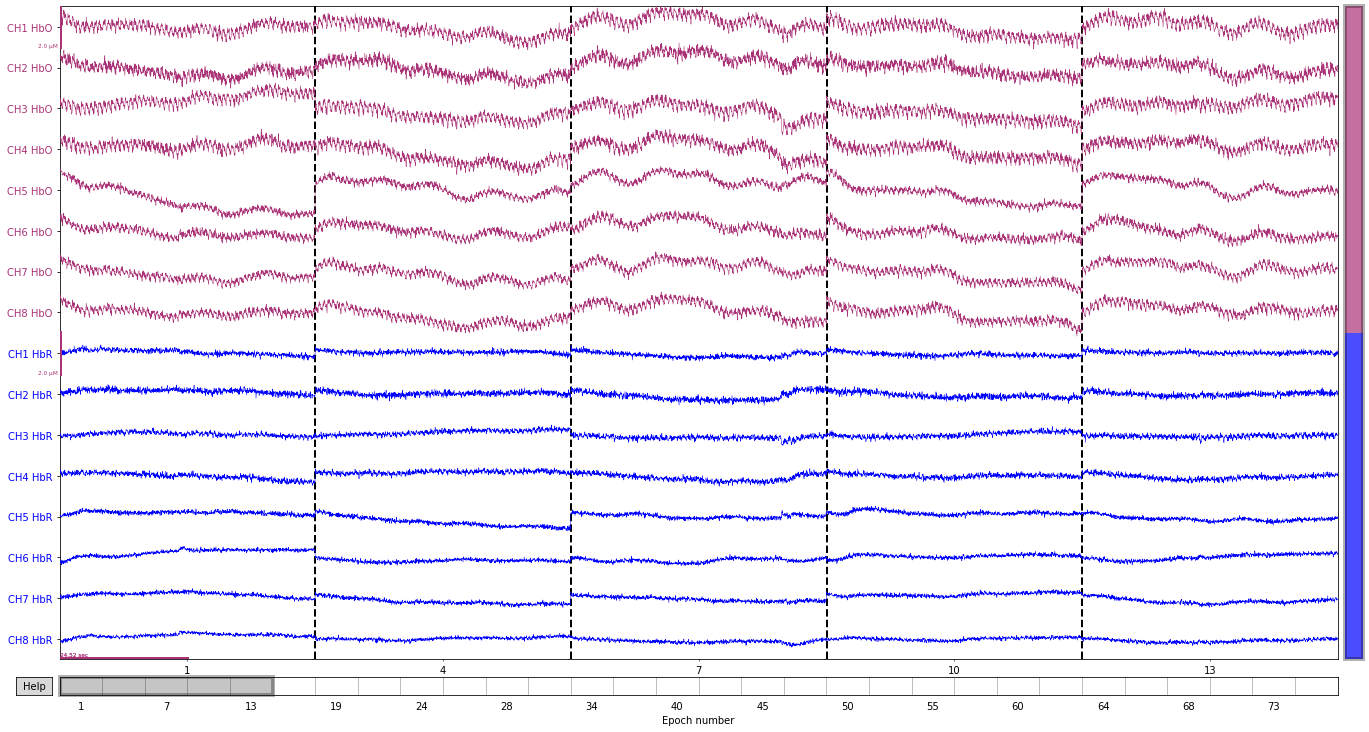

In [11]:
graph = epochs.plot(scalings=1e-6, n_epochs=5)

## Filtering

**It is easy to filter an MNE-Python object, for example we can apply a Butterworth bandpass filter:**

In [12]:
# Define the filter parameters
bandpass = [0.01, 1]
iir_params = {'order': 4, 'ftype': 'butter', 'output': 'sos'}

# Filter the Raw object
raw.filter(bandpass[0], bandpass[1], method='iir', iir_params=iir_params)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



<RawArray | 17 x 55454 (2218.1 s), ~7.2 MB, data loaded>

**If we plot the data again, we see if filtered:**

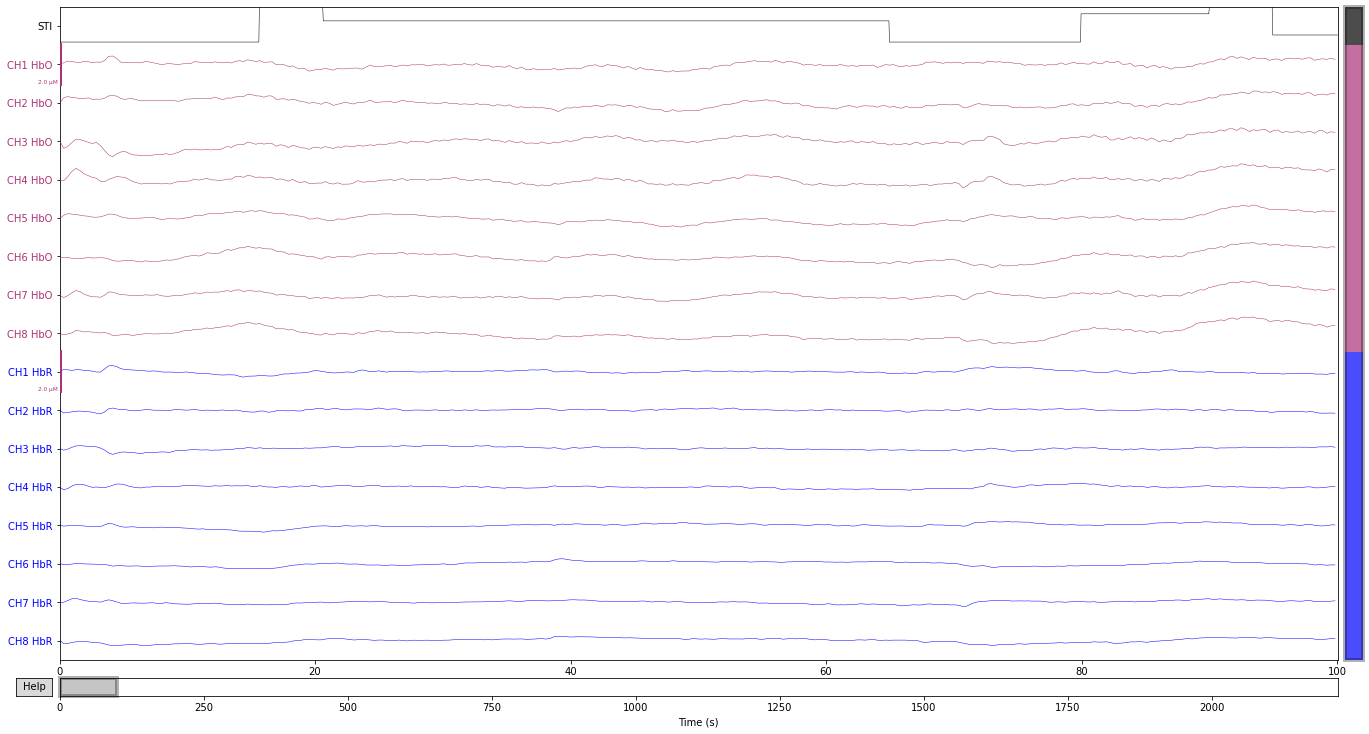

In [13]:
graph = raw.plot(scalings=1e-6, duration=100)

**We can do the same with our Epochs object instead:**

Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



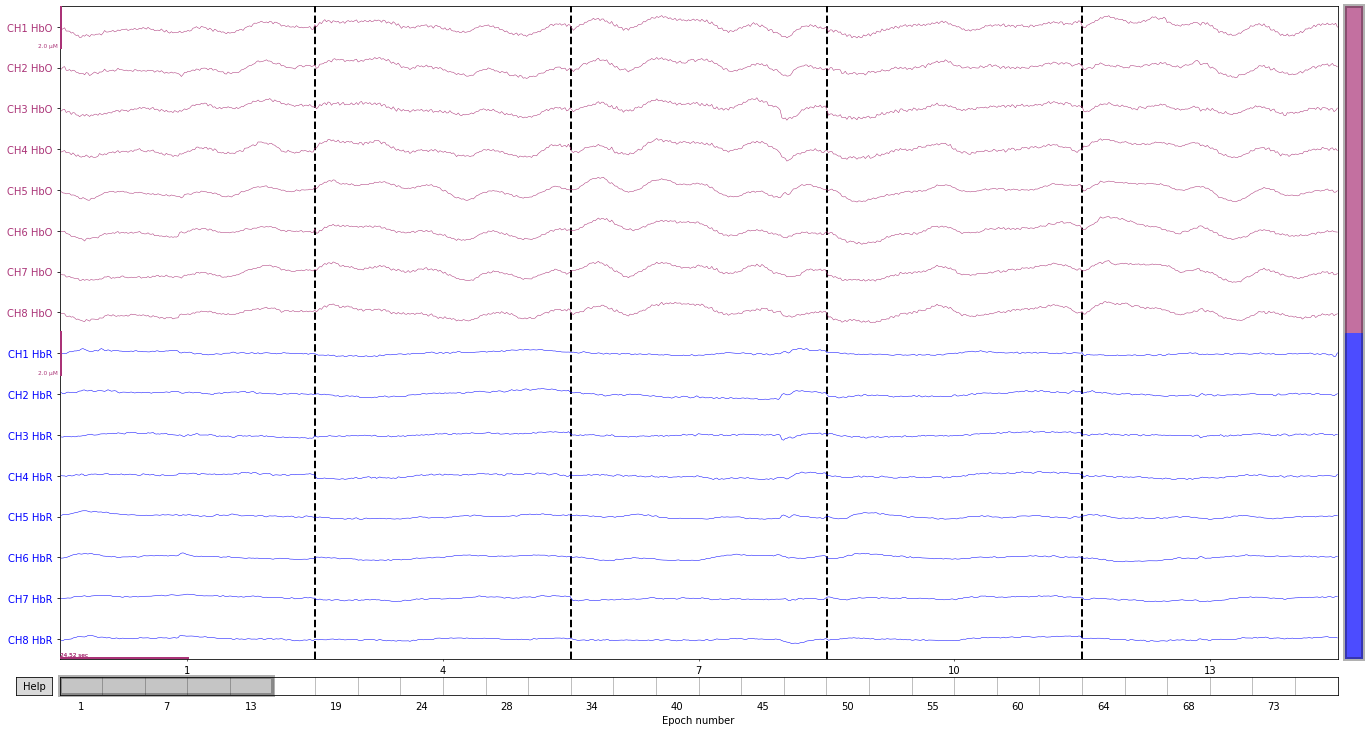

In [14]:
# Filter the Epochs object
epochs.filter(bandpass[0], bandpass[1], method='iir', iir_params=iir_params)

# Plot the filtered epochs
graph = epochs.plot(scalings=1e-6, n_epochs=5)

## Combining channels

**Since MNE version 0.21 we can combine channels easily by region of interest (ROI).**

In [15]:
from mne.channels import combine_channels  # requires MNE 0.21 or greater

In [16]:
# Create a dictionnary with channel indices
roi_dict = {'Right HbO': [0, 2, 4, 6],
            'Right HbR': [1, 3, 5, 7],
            'Left HbO': [8, 10, 12, 14],
            'Left HbR': [9, 11, 13, 15]}
print("Original channels:\n{}".format(CH_NAMES))
print("Combined channels:\n{}".format([key for key in roi_dict]))

Original channels:
['CH1 HbO', 'CH1 HbR', 'CH2 HbO', 'CH2 HbR', 'CH3 HbO', 'CH3 HbR', 'CH4 HbO', 'CH4 HbR', 'CH5 HbO', 'CH5 HbR', 'CH6 HbO', 'CH6 HbR', 'CH7 HbO', 'CH7 HbR', 'CH8 HbO', 'CH8 HbR']
Combined channels:
['Right HbO', 'Right HbR', 'Left HbO', 'Left HbR']


**We can average channels of a Raw object by side:**

Creating RawArray with float64 data, n_channels=5, n_times=55454
    Range : 0 ... 55453 =      0.000 ...  2218.120 secs
Ready.


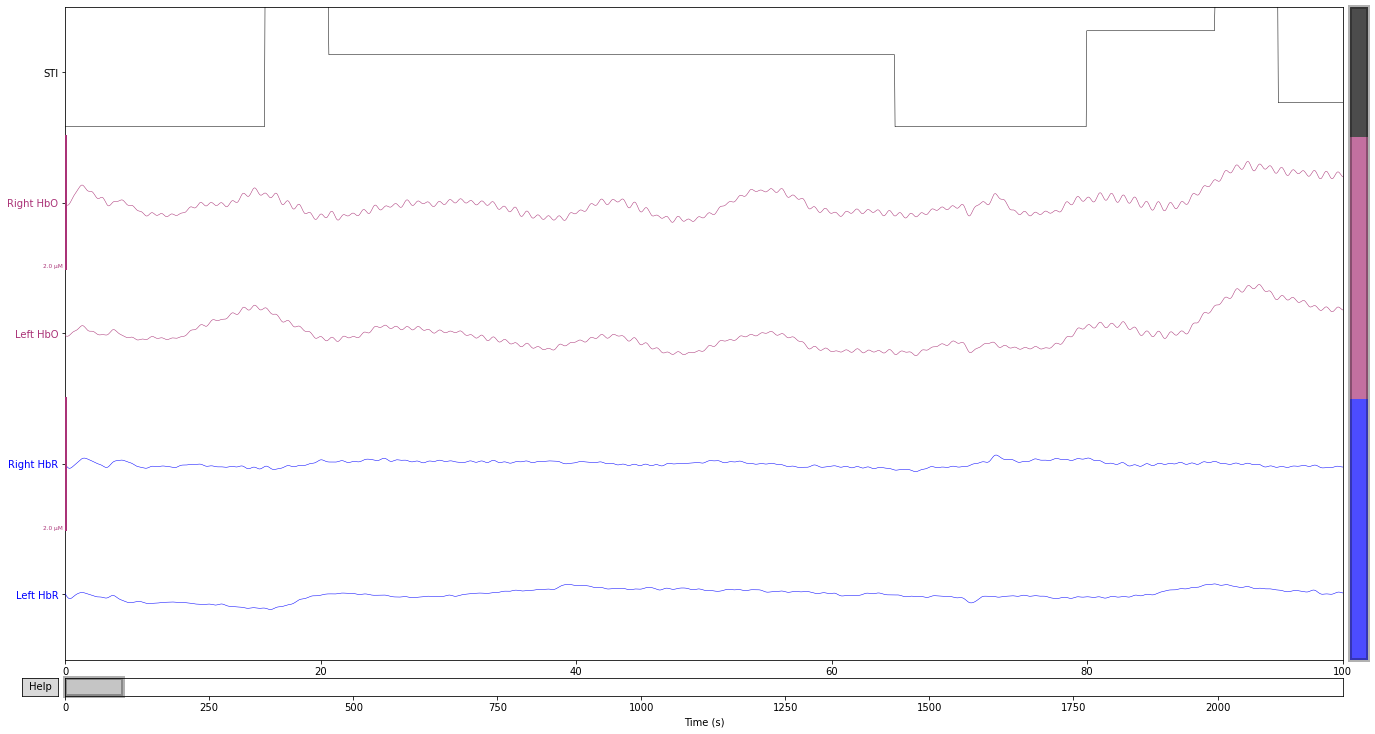

In [17]:
# Average channels by side
roi_raw = combine_channels(raw, roi_dict, method='mean', keep_stim=True)

# Plot the combined Raw
graph = roi_raw.plot(scalings=1e-6, duration=100)

## Access data

**We can access Raw data as a NumPy array:**

In [18]:
np_raw = raw.get_data()
print(np_raw.shape)

(17, 55454)


**We can also access Epochs data as a NumPy array:**

In [19]:
np_epochs = epochs.get_data()
print(np_epochs.shape)

(30, 17, 1226)


**Here our Epochs object has 17 channels (16 fNIRS channels and the stimulus channel that we appended), but we can pick only fNIRS channels:**

In [20]:
epochs_fnirs = epochs.copy().pick_types(fnirs=True)
np_epochs_fnirs = epochs_fnirs.get_data()
print(np_epochs_fnirs.shape)

(30, 16, 1226)


**Finally, we can also access events:**

In [21]:
print(epochs_fnirs.events)

[[  516     5     3]
 [ 2374     5     1]
 [ 4231     5     1]
 [ 6089     5     1]
 [ 7946     5     3]
 [ 9805     5     1]
 [11661     5     2]
 [13268     5     2]
 [15127     5     1]
 [16733     5     3]
 [18341     5     1]
 [20200     5     3]
 [22058     5     2]
 [23915     5     2]
 [25774     5     2]
 [30438     5     3]
 [32047     5     2]
 [33907     5     2]
 [35515     5     2]
 [37126     5     2]
 [38983     5     3]
 [40842     5     3]
 [42453     5     1]
 [44060     5     3]
 [45670     5     3]
 [47279     5     1]
 [48888     5     1]
 [50499     5     1]
 [52359     5     3]
 [53969     5     2]]


 The first column contains the event time in samples and the third column contains the event id (label).

**From that, we can extract labels:**

In [22]:
labels = epochs_fnirs.events[:, 2]
print(labels)

[3 1 1 1 3 1 2 2 1 3 1 3 2 2 2 3 2 2 2 2 3 3 1 3 3 1 1 1 3 2]


Those NumPy arrays and label list can then be used with various data science libraries ([scikit-learn](https://scikit-learn.org/stable/index.html), [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/)...).